# Explore Data and Look for Outliers

In [1]:
# Imports
import math
import numpy as np
import pandas as pd
from scipy.stats import shapiro 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import adjusted_rand_score

## Missing data

In [2]:
# Read merged dataFrame
file='DataPatientsWithGT.csv'
df = pd.read_csv(file,sep=';',index_col=0, na_values='n.a.', dtype={'Stage': 'object', 'Age': 'float64'})

In [3]:
# print(df.shape)
df.head(1)

,ENSG00000000419,ENSG00000000460,ENSG00000000938,ENSG00000001036,ENSG00000001461,ENSG00000001497,ENSG00000001629,ENSG00000001631,ENSG00000002330,ENSG00000002549,...,Sample ID,Stage,Sex,Age,Sample-supplying institution,Training series,Evaluation series,Validation series,Class_group,Patient_group
1-Vumc-HD-101-TR922,3.9378,1.555228,7.445603,13.655275,11.121538,3.471206,5.986674,4.978068,46.477912,25.632179,...,Vumc-HD-101-TR922,NaN,F,35.0,Institute 13,1,0,0,nonMalignant,Asymptomatic controls


In [4]:
# Missing data
list_na_columns = df.columns[df.isna().any()].tolist()
print("Columns with Nans", list_na_columns)

Columns with Nans ['Stage', 'Sex', 'Age']


In [5]:
print("Number of Nans in Stage: ", df['Stage'].isna().sum()) # 723 non-malig + 256 malig
print("Number of Nans in Sex: ", df['Sex'].isna().sum())
print("Number of Nans in Age: ", df['Age'].isna().sum())

Number of Nans in Stage:  979
Number of Nans in Sex:  20
Number of Nans in Age:  23


## Check for Outliers


We will remove those patients that do not belong to their group. 

In this case, the outliers analysis will be done with those genes that belong the one of the two paper's biomarker panels.

We will focus on Class_group: Malignant versus nonMalignant

In [6]:
# Remove columns that are repeated or irrelevant
df_class= df.drop(['Sample ID', 'Stage', 'Sex', 'Age', 'Sample-supplying institution', 'Training series', 'Evaluation series', 'Validation series', 'Patient_group'], axis=1, inplace=False)

### Find Biomarker panel genes

In [24]:
file1='1-s2.0-S1535610822003701-mmc4.xlsx'
df1 = pd.read_excel(file1, header=2, index_col=0)
df1.head(5)

,ensembl_gene_id,hgnc_symbol,description,In Tumor-site-of-origin algorithm biomarker panel
#,,,,
1,ENSG00000133742,CA1,carbonic anhydrase I [Source:HGNC Symbol;Acc:1...,0
2,ENSG00000013306,SLC25A39,"solute carrier family 25, member 39 [Source:HG...",0
3,ENSG00000223609,HBD,"hemoglobin, delta [Source:HGNC Symbol;Acc:4829]",0
4,ENSG00000103316,CRYM,"crystallin, mu [Source:HGNC Symbol;Acc:2418]",0
5,ENSG00000142089,IFITM3,interferon induced transmembrane protein 3 [So...,1


In [25]:
df1.drop(["hgnc_symbol","description"], axis=1, inplace=True)
df1.rename(columns={'In Tumor-site-of-origin algorithm biomarker panel' : 'biomarker panel'}, inplace=True)
df1.head(5)

,ensembl_gene_id,biomarker panel
#,,
1,ENSG00000133742,0
2,ENSG00000013306,0
3,ENSG00000223609,0
4,ENSG00000103316,0
5,ENSG00000142089,1


In [32]:
df1.shape

(493, 2)

In [26]:
file2='1-s2.0-S1535610822003701-mmc5.xlsx'
df2 = pd.read_excel(file2, header=2, index_col=0)
df2.drop(["hgnc_symbol","description"], axis=1, inplace=True)
df2.rename(columns={'In Pan-cancer algorithm biomarker panel' : 'biomarker panel'}, inplace=True)
df2.head(5)

,ensembl_gene_id,biomarker panel
#,,
1,ENSG00000243449,0
2,ENSG00000159377,0
3,ENSG00000237973,0
4,ENSG00000177556,1
5,ENSG00000168028,0


In [33]:
df2.shape

(93, 2)

In [27]:
# Vertical concatenation = concat on top of another, increase no of rows
dft = pd.concat([df1,df2], axis = 0)
dft.head(5)

,ensembl_gene_id,biomarker panel
#,,
1,ENSG00000133742,0
2,ENSG00000013306,0
3,ENSG00000223609,0
4,ENSG00000103316,0
5,ENSG00000142089,1


In [34]:
dft.shape

(586, 2)

In [28]:
# Keep the ones that are in one of the biomarker panels
dfbp = dft.loc[dft['biomarker panel'] == 1]
dfbp.head(5)


,ensembl_gene_id,biomarker panel
#,,
5,ENSG00000142089,1
49,ENSG00000114439,1
127,ENSG00000109971,1
192,ENSG00000096060,1
250,ENSG00000177556,1


In [30]:
dfbp.shape

(20, 2)

In [31]:
# Let's check there is no gene repetition
dfbp['ensembl_gene_id'].nunique()

10

In [35]:
# Let's keep only one row per gene
dfbpr = dfbp.drop_duplicates()
dfbpr.head(5)

,ensembl_gene_id,biomarker panel
#,,
5,ENSG00000142089,1
49,ENSG00000114439,1
127,ENSG00000109971,1
192,ENSG00000096060,1
250,ENSG00000177556,1


In [36]:
dfbpr.shape

(10, 2)

### Get a subset of the database that contains only those 10 genes

In [40]:
# df_class contains our database
# dfbpr contains the genes from biomarker panel
list_of_genes = list(dfbpr['ensembl_gene_id'].values)
print(list_of_genes)


['ENSG00000142089', 'ENSG00000114439', 'ENSG00000109971', 'ENSG00000096060', 'ENSG00000177556', 'ENSG00000071859', 'ENSG00000228651', 'ENSG00000198168', 'ENSG00000215301', 'ENSG00000142546']


In [62]:
#Check if any of these genes is in the genes removed
file_g = 'List_of_genes_to_check.csv'
df_g = pd.read_csv(file_g, header=None)
# df_g.shape
df_g.head(5)
genes_removed = list(df_g[0].values)
list_of_genes_r = []
# print(len(genes_removed))
for elem in list_of_genes:
    if elem in genes_removed:
        print(elem, " was removed")
    else:
        list_of_genes_r.append(elem)

ENSG00000228651  was removed


In [63]:
# We will have to remove this gene from the list to be able to continue
print(list_of_genes_r)

['ENSG00000142089', 'ENSG00000114439', 'ENSG00000109971', 'ENSG00000096060', 'ENSG00000177556', 'ENSG00000071859', 'ENSG00000198168', 'ENSG00000215301', 'ENSG00000142546']


In [65]:
list_of_columns = list_of_genes_r + ['Class_group']
df_class = df_class[list_of_columns]
df_class.head(5)

,ENSG00000142089,ENSG00000114439,ENSG00000109971,ENSG00000096060,ENSG00000177556,ENSG00000071859,ENSG00000198168,ENSG00000215301,ENSG00000142546,Class_group
1-Vumc-HD-101-TR922,67.059569,8.627443,41.248578,4.489009,68.950936,85.789872,147.288125,21.586292,47.175239,nonMalignant
2-Vumc-HD-103-TR923,78.833667,19.331437,389.800978,23.494897,97.368677,87.399163,63.834012,22.152919,473.977402,nonMalignant
3-Vumc-HD-108-TR924,162.642851,18.138539,415.679187,23.496555,159.133155,73.465689,101.289140,64.458085,258.482264,nonMalignant
4-Vumc-HD-127-TR925,392.688648,12.747787,175.534393,3.852725,192.408193,114.654656,72.006330,10.897996,629.017688,nonMalignant
5-Vumc-HD-130-TR926,233.628460,13.872507,161.269720,3.909808,170.646511,67.630428,103.709822,5.529732,374.686970,nonMalignant


In [66]:
df_class.shape

(2351, 10)

### Check data Distribution

In [67]:
# Check data distribution
# If data is normally distributed (in more general sense, symmetrically distributed), then the result with PCA is more robust.
# Otherwise, It is better to use t-SNE


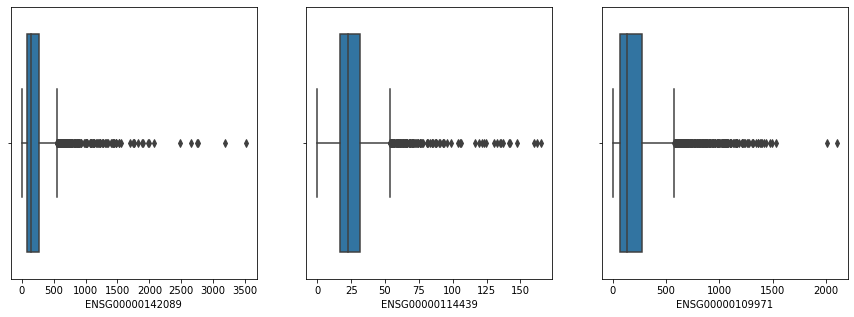

In [68]:
# Represent the genes distribution
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(x=df[list_of_genes_r[0]], ax=ax[0])
sns.boxplot(x=df[list_of_genes_r[1]], ax=ax[1])
sns.boxplot(x=df[list_of_genes_r[2]], ax=ax[2])
plt.show()

They are clearly not simetrical and not following a normal distribution.

We can also perform a Shapiro-Wilk Test. If the p-value of the test is greater than α = .05, then the data is assumed to be normally distributed.


In [69]:
np.random.seed(42)
shapiro(df[list_of_genes_r[0]])

ShapiroResult(statistic=0.6144758462905884, pvalue=0.0)

Since the p-value is less than .05, we reject the null hypothesis of the Shapiro-Wilk test.

This means we have sufficient evidence to say that the sample data does not come from a normal distribution.

In [70]:
shapiro(df[list_of_genes_r[1]])

ShapiroResult(statistic=0.7752242088317871, pvalue=0.0)

In [71]:
shapiro(df[list_of_genes_r[2]])

ShapiroResult(statistic=0.7244303226470947, pvalue=0.0)

Same for the other two genes tested.

### Apply tSNE to look for abnormalities (Malignant vs. nonMalignant)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2351 samples in 0.003s...
[t-SNE] Computed neighbors for 2351 samples in 0.067s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2351
[t-SNE] Computed conditional probabilities for sample 2000 / 2351
[t-SNE] Computed conditional probabilities for sample 2351 / 2351
[t-SNE] Mean sigma: 47.970049
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.512978
[t-SNE] KL divergence after 4000 iterations: 1.204949


[Text(0.5, 1.0, 'tSNE')]

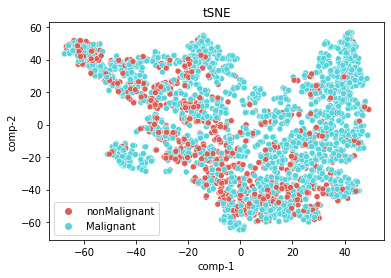

In [72]:
X = df_class[list_of_columns[0:-1]]
y = df_class[list_of_columns[-1]]

tsne = TSNE(n_components=2, verbose=1, random_state=42, learning_rate='auto', init='random', n_iter=4000)
z = tsne.fit_transform(X)

df_z = pd.DataFrame()
df_z["y"] = y
df_z["comp-1"] = z[:,0]
df_z["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df_z.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df_z).set(title="tSNE") 

### Apply PCA to look for abnormalities (although we know data does not follow a normal distribution)


c:\Users\acard\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

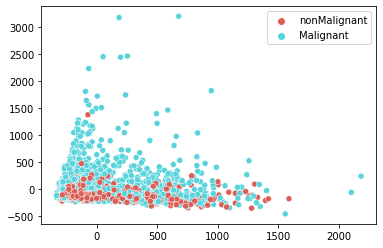

In [73]:
X = df_class[list_of_columns[0:-1]]
y = df_class[list_of_columns[-1]]

pca = PCA(n_components=2, random_state=42)
z = pca.fit_transform(X)

sns.scatterplot(z[:, 0], z[:, 1], hue=y.tolist(), palette=sns.color_palette("hls", 2))

In [76]:
# Find potential outliers
threshold = 2000
index_outliers_PCA = [i for i,v in enumerate(z) if (v[0] > threshold or v[1] > threshold)]
print(index_outliers_PCA)

# print(y.iloc[[index_outliers[0]]])
# print(y.iloc[[index_outliers[1]]])

[465, 550, 1206, 1488, 1577, 1768, 1967, 2183]


### Apply robust PCA (rPCA) to look for abnormalities

In [77]:
# Download and import robust PCA from https://github.com/dganguli/robust-pca
# https://stackoverflow.com/questions/40721260/how-to-use-robust-pca-output-as-principal-component-eigenvectors-from-traditio
from robust_pca_master.r_pca import R_pca

The robust-pca code factors the data matrix X into two matrices, L and S which are "low-rank" and "sparse" matrices. 
* L is what's mostly constant between the various observations, while 
* S is what varies. 

If you just want the eigenvectors, treat the S as junk (the "large outliers" you're wanting to clip out) and do an eigenanalysis on the L matrix.

iteration: 1, error: 166.10539853776277
iteration: 100, error: 2.5116364882206716
iteration: 200, error: 2.206987696296707
iteration: 300, error: 1.329017463710063
iteration: 400, error: 0.9285780733070159
iteration: 500, error: 0.5439827912694704
iteration: 600, error: 0.3580279467699644
iteration: 700, error: 0.15640851234085473
iteration: 800, error: 0.12847940532739666
iteration: 900, error: 0.044115685978193875
iteration: 1000, error: 0.027328191340354257


c:\Users\acard\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

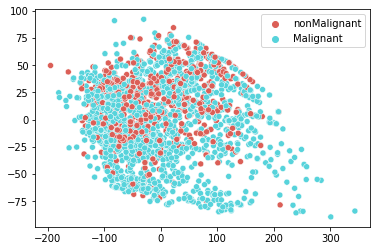

In [78]:
X = df_class[list_of_columns[0:-1]]
y = df_class[list_of_columns[-1]]

L, S = R_pca(X).fit()

pca = PCA(n_components=2, random_state=42)
z = pca.fit_transform(L)

sns.scatterplot(z[:, 0], z[:, 1], hue=y.tolist(), palette=sns.color_palette("hls", 2))

In [79]:
# Find potential outliers
threshold = 300
index_outliers_rPCA = [i for i,v in enumerate(z) if v[0] > threshold]
print(index_outliers_rPCA)



[1752, 1768]


### Apply Multivariate outlier detection with PyOD

Idea from https://towardsdatascience.com/how-to-perform-multivariate-outlier-detection-in-python-pyod-for-machine-learning-b0a9c557a21c

PyOD is the most comprehensive and scalable Python library for detecting outlying objects in multivariate data. 

Isolation Forest: works on almost any type of dataset but is specifically designed for high-dimensional, complex ones. Even though it is a collection of different type of decision trees, called ITrees, it is fast and has a high performance. It can also handle data with irregular, non-normal distributions.

Local Outlier Factor: particularly good for datasets with data points that are clustered together as it calculates anomaly scores using local density. It works well with high-dimensional data and can be faster than IForest

@article{zhao2019pyod,
    author  = {Zhao, Yue and Nasrullah, Zain and Li, Zheng},
    title   = {PyOD: A Python Toolbox for Scalable Outlier Detection},
    journal = {Journal of Machine Learning Research},
    year    = {2019},
    volume  = {20},
    number  = {96},
    pages   = {1-7},
    url     = {http://jmlr.org/papers/v20/19-011.html}
}

In [80]:
X = df_class[list_of_columns[0:-1]]
y = df_class[list_of_columns[-1]]

# pip install pyod
# from pyod.models.lof import LOF
from pyod.models.iforest import IForest

# predict_proba returns two columns for each sample:
#     the first column is the probability of the sample being an inlier and 
#     the second is the probability of the sample being an outlier. 

iforest = IForest(n_estimators=500).fit(X)
probs = iforest.predict_proba(X)

# We can select samples that have at least 80%, 90%, or n% outlier probability.
# Set a confidence threshold to choose outliers based on probability confidence
# If you are dealing with sensitive data like medical records where it is critical to avoid false positives, 
# you should aim for over 90%. 95% and 99% are pretty common as well.
threshold = 0.9

# Create a mask that returns True if probs over threshold
is_outlier = probs[:, 1] > threshold
outliers_X_probs_IF = X[is_outlier]

# Count up the outliers
num_outliers = len(outliers_X_probs_IF)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(X):.4f}")


c:\Users\acard\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


The number of outliers: 3
Percentage of outliers: 0.0013


In [81]:
outliers_X_probs_IF

,ENSG00000142089,ENSG00000114439,ENSG00000109971,ENSG00000096060,ENSG00000177556,ENSG00000071859,ENSG00000198168,ENSG00000215301,ENSG00000142546
640-NKI-Sarc-2576-TR2445,3194.446287,52.552430,15.878103,46.655607,1279.226012,780.998299,426.301354,0.000000,77.826401
2622-UMCG-NSCLC-988-TR2788,1885.905442,58.841240,74.668411,41.791008,736.615339,971.620331,387.638212,0.000000,1254.811403
2709-UMCG-NCSLC-1081-TR3028,352.399171,46.499853,655.102857,116.376432,855.356065,719.568524,360.547577,35.587868,2679.753165


In [85]:
index_outliers_IF = np.argwhere(is_outlier == True).tolist()
print(index_outliers_IF)

[[550], [1699], [1768]]


In [87]:
X = df_class[list_of_columns[0:-1]]
y = df_class[list_of_columns[-1]]

# pip install pyod
from pyod.models.lof import LOF
# from pyod.models.iforest import IForest

# predict_proba returns two columns for each sample:
#     the first column is the probability of the sample being an inlier and 
#     the second is the probability of the sample being an outlier. 

lof = LOF(n_neighbors=30).fit(X)
probs = lof.predict_proba(X)

# We can select samples that have at least 80%, 90%, or n% outlier probability.
# Set a confidence threshold to choose outliers based on probability confidence
# If you are dealing with sensitive data like medical records where it is critical to avoid false positives, 
# you should aim for over 90%. 95% and 99% are pretty common as well.
threshold = 0.9

# Create a mask that returns True if probs over threshold
is_outlier = probs[:, 1] > threshold
outliers_X_probs_LOF = X[is_outlier]

# Count up the outliers
num_outliers = len(outliers_X_probs_LOF)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(X):.4f}")

The number of outliers: 1
Percentage of outliers: 0.0004


In [88]:
outliers_X_probs_LOF

,ENSG00000142089,ENSG00000114439,ENSG00000109971,ENSG00000096060,ENSG00000177556,ENSG00000071859,ENSG00000198168,ENSG00000215301,ENSG00000142546
2761-TR4683-NSCLC-NKI,523.033328,78.123565,157.966049,39.124714,17.912176,89.309157,51.703116,779.72032,73.422099


In [89]:
index_outliers_LOF = np.argwhere(is_outlier == True).tolist()
print(index_outliers_LOF)

[[1804]]


### Apply DBSCAN to look for abnormalities (Malignant vs. nonMalignant)

Intenta ajustar el algoritmo DBSCAN para minimizar las diferencias entre ground truth y los clústeres arrojados por el algoritmo. El propio algoritmo DBSCAN, si se ajusta correctamente, sirve también para detectar outliers.

In [106]:
X = df_class[list_of_columns[0:-1]]
y = df_class[list_of_columns[-1]]
# Apply DBSCAN
# Cluster labels. Noisy samples are given the label -1.
# Find eps and min_samples to obtain 2 groups
dbscan = DBSCAN(eps=150, min_samples=5)
clusters = dbscan.fit_predict(X)
unique, counts = np.unique(clusters, return_counts=True)
print("Clusters: ", unique)
print("Elements per cluster: ", counts)

Clusters:  [-1  0  1  2  3  4  5  6]
Elements per cluster:  [ 432 1888    5    6    6    5    5    4]


In [107]:
# index_outliers_DBSCAN = np.argwhere(clusters == -1).tolist()
# print(index_outliers_DBSCAN)


In [30]:
#DBSCAN performance:
# A mayor ARI, mejor
# print("ARI =", adjusted_rand_score(y, clusters))

### Merge all the information

In [112]:
print("Outliers from PCA: ", index_outliers_PCA)
print("Outliers from rPCA: ", index_outliers_rPCA)

index_outliers_IF_flat = [item for sublist in index_outliers_IF for item in sublist]
print("Outliers from IF: ", index_outliers_IF_flat)

index_outliers_LOF_flat = [item for sublist in index_outliers_LOF for item in sublist]
print("Outliers from LOF: ", index_outliers_LOF_flat)


Outliers from PCA:  [465, 550, 1206, 1488, 1577, 1768, 1967, 2183]
Outliers from rPCA:  [1752, 1768]
Outliers from IF:  [550, 1699, 1768]
Outliers from LOF:  [1804]


In [115]:
# Criteria: remove those outliers that appear at least in 2 lists
index_outliers_total = index_outliers_PCA + index_outliers_rPCA + index_outliers_IF_flat + index_outliers_LOF_flat
index_outliers_repeated = list(set([i for i in index_outliers_total if index_outliers_total.count(i)>1]))
print(index_outliers_repeated)

[1768, 550]


### Remove outliers and save dataset

In [120]:
print(df.shape)
df.head(2)

(2351, 5261)


,ENSG00000000419,ENSG00000000460,ENSG00000000938,ENSG00000001036,ENSG00000001461,ENSG00000001497,ENSG00000001629,ENSG00000001631,ENSG00000002330,ENSG00000002549,...,Sample ID,Stage,Sex,Age,Sample-supplying institution,Training series,Evaluation series,Validation series,Class_group,Patient_group
1-Vumc-HD-101-TR922,3.93780,1.555228,7.445603,13.655275,11.121538,3.471206,5.986674,4.978068,46.477912,25.632179,...,Vumc-HD-101-TR922,NaN,F,35.0,Institute 13,1,0,0,nonMalignant,Asymptomatic controls
2-Vumc-HD-103-TR923,67.84106,2.119756,113.660546,18.024223,2.863275,15.139871,3.036190,18.222689,40.741981,42.549333,...,Vumc-HD-103-TR923,NaN,F,54.0,Institute 13,0,1,0,nonMalignant,Asymptomatic controls


In [123]:
index_outliers_repeated

[1768, 550]

In [6]:
# index_outliers_repeated = [1768, 550]

In [7]:
df_wo = df.drop(df.index[index_outliers_repeated])

In [8]:
df_wo.shape

(2349, 5261)

In [9]:
df_wo.head(2)

,ENSG00000000419,ENSG00000000460,ENSG00000000938,ENSG00000001036,ENSG00000001461,ENSG00000001497,ENSG00000001629,ENSG00000001631,ENSG00000002330,ENSG00000002549,...,Sample ID,Stage,Sex,Age,Sample-supplying institution,Training series,Evaluation series,Validation series,Class_group,Patient_group
1-Vumc-HD-101-TR922,3.93780,1.555228,7.445603,13.655275,11.121538,3.471206,5.986674,4.978068,46.477912,25.632179,...,Vumc-HD-101-TR922,NaN,F,35.0,Institute 13,1,0,0,nonMalignant,Asymptomatic controls
2-Vumc-HD-103-TR923,67.84106,2.119756,113.660546,18.024223,2.863275,15.139871,3.036190,18.222689,40.741981,42.549333,...,Vumc-HD-103-TR923,NaN,F,54.0,Institute 13,0,1,0,nonMalignant,Asymptomatic controls


In [10]:
# Save dataFrame without outliers
file='DataPatientsWithGTNoOutliers.csv'
df_wo.to_csv(file, sep=';', na_rep='n.a.')